# UBER

## Problem Statement : 
- Develop a predictive model to accurately forecast hourly traffic volumes at different road junctions based on historical traffic data

## Component-2: Exploratory Data Analysis & Data Preparation

### Workflow :
- #### Data Cleaning & Pre-processing
    Load Raw Data:
    Read the collected data into pandas DataFrames.


- #### Clean Data:
    Handle missing values using methods like imputation or removal (df.fillna(), df.dropna()).
    Remove duplicates (df.drop_duplicates()).
    Correct data types (df.astype()).


- #### Aggregate traffic data:
  - Compile traffic data into hourly intervals for each junction.
  - Ensure data includes relevant details such as vehicle counts.


- #### Preprocess the data:
    Normalize or standardize the data to facilitate comparison across different time periods and junctions.

- #### Feature Engineering and Selection
  - 1. #### Create new features from raw data:
        Generate time-based features such as hour of the day, day of the week, and month.
        Develop lag features by including traffic data from previous hours or days to capture temporal dependencies.
        Create binary indicators for weekends and special events to account for their impact on traffic.

  - 2. #### Evaluate feature importance:
        Use statistical methods and machine learning techniques (e.g., correlation analysis, feature importance from tree-based models) to assess the           relevance of each feature.
        Select the most influential features for model training to improve efficiency and performance.

### Step -1 : Reading the data

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [7]:
# Loading the dataset into a Dataframe

uber_df = pd.read_csv("Dataset_Uber Traffic.csv")

In [8]:
uber_df.head()

,DateTime,Junction,Vehicles,ID
0,01/11/15 0:00,1,15,20151101001
1,01/11/15 1:00,1,13,20151101011
2,01/11/15 2:00,1,10,20151101021
3,01/11/15 3:00,1,7,20151101031
4,01/11/15 4:00,1,9,20151101041


In [9]:
# checking the shape of the dataset
uber_df.shape

(48120, 4)

In [10]:
# description of dataset
uber_df.describe()

,Junction,Vehicles,ID
count,48120.000000,48120.000000,4.812000e+04
mean,2.180549,22.791334,2.016330e+10
std,0.966955,20.750063,5.944854e+06
min,1.000000,1.000000,2.015110e+10
25%,1.000000,9.000000,2.016042e+10
50%,2.000000,15.000000,2.016093e+10
75%,3.000000,29.000000,2.017023e+10
max,4.000000,180.000000,2.017063e+10


In [11]:
uber_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DateTime  48120 non-null  object
 1   Junction  48120 non-null  int64 
 2   Vehicles  48120 non-null  int64 
 3   ID        48120 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


### Step-2: Cleaning the Data

In [13]:
# checking for null values
uber_df.isnull().sum()

DateTime    0
Junction    0
Vehicles    0
ID          0
dtype: int64

In [14]:
# Check for duplicates
uber_df.duplicated().sum()


np.int64(0)

In [15]:
# Remove duplicates from the dataset
uber_df = uber_df.drop_duplicates()

In [16]:
uber_df.shape

(48120, 4)

In [17]:
# Parse Datetime
uber_df['DateTime'] = pd.to_datetime(uber_df['DateTime'],errors= 'coerce')

In [18]:
# Ensure numeric vehicles
uber_df['Vehicles'] = pd.to_numeric(uber_df['Vehicles'], errors = 'coerce')

In [19]:
uber_df.head()

,DateTime,Junction,Vehicles,ID
0,2015-01-11 00:00:00,1,15,20151101001
1,2015-01-11 01:00:00,1,13,20151101011
2,2015-01-11 02:00:00,1,10,20151101021
3,2015-01-11 03:00:00,1,7,20151101031
4,2015-01-11 04:00:00,1,9,20151101041


### Step-3: Aggregate traffic data

In [21]:
# Aggregate to hourly per junction

uber_df = uber_df.set_index('DateTime')

In [22]:
hourly = uber_df.groupby('Junction').resample('H')['Vehicles'].sum().reset_index()
hourly.head()

,Junction,DateTime,Vehicles
0,1,2015-01-11 00:00:00,15
1,1,2015-01-11 01:00:00,13
2,1,2015-01-11 02:00:00,10
3,1,2015-01-11 03:00:00,7
4,1,2015-01-11 04:00:00,9


### Step-4: Preprocess the data:


In [24]:
# Normalize or standardize the data to facilitate comparison across different time periods and junctions.

In [25]:
# Standardization is the better to use — it handles different spreads, keeps negative/positive deviations meaningful, and is robust with outliers.

In [26]:
hourly_scaled = hourly.copy()

scaler = StandardScaler()
hourly_scaled['Vehicles_standard'] = scaler.fit_transform(hourly_scaled[['Vehicles']])


In [27]:
hourly_scaled.head()

,Junction,DateTime,Vehicles,Vehicles_standard
0,1,2015-01-11 00:00:00,15,0.105143
1,1,2015-01-11 01:00:00,13,0.001506
2,1,2015-01-11 02:00:00,10,-0.153950
3,1,2015-01-11 03:00:00,7,-0.309406
4,1,2015-01-11 04:00:00,9,-0.205768


In [28]:
hourly_scaled = hourly_scaled.drop(['Vehicles'],axis=1)

### Feature Engineering and Selection

#### 1. Create new features from raw data:


In [31]:
# Extract Time based 
hourly_scaled['hour']= hourly_scaled['DateTime'].dt.hour
hourly_scaled['dayofweek'] = hourly_scaled['DateTime'].dt.dayofweek
hourly_scaled['month'] = hourly_scaled['DateTime'].dt.month
hourly_scaled['isweekend'] = (hourly_scaled['dayofweek']>5).astype(int)

In [32]:
hourly_scaled.head()

,Junction,DateTime,Vehicles_standard,hour,dayofweek,month,isweekend
0,1,2015-01-11 00:00:00,0.105143,0,6,1,1
1,1,2015-01-11 01:00:00,0.001506,1,6,1,1
2,1,2015-01-11 02:00:00,-0.153950,2,6,1,1
3,1,2015-01-11 03:00:00,-0.309406,3,6,1,1
4,1,2015-01-11 04:00:00,-0.205768,4,6,1,1


In [33]:
# Generate Indian holidays for the dataset period
import holidays
start_date, end_date = hourly_scaled["DateTime"].min(), hourly_scaled["DateTime"].max()
indian_holidays = holidays.India(years=range(start_date.year, end_date.year + 1))

# Create holiday indicator
hourly_scaled["is_holiday"] = hourly_scaled["DateTime"].dt.date.astype("datetime64[ns]").isin(indian_holidays).astype(int)

In [34]:
hourly_scaled.head()

,Junction,DateTime,Vehicles_standard,hour,dayofweek,month,isweekend,is_holiday
0,1,2015-01-11 00:00:00,0.105143,0,6,1,1,0
1,1,2015-01-11 01:00:00,0.001506,1,6,1,1,0
2,1,2015-01-11 02:00:00,-0.153950,2,6,1,1,0
3,1,2015-01-11 03:00:00,-0.309406,3,6,1,1,0
4,1,2015-01-11 04:00:00,-0.205768,4,6,1,1,0


In [35]:
# Lag Features ( 1hour, 24 hours, 168 (previous week))
for lag in [1,24,168]:
    hourly_scaled[f"lag_{lag}"] = hourly_scaled.groupby("Junction")["Vehicles_standard"].shift(lag)

In [36]:
hourly_scaled

,Junction,DateTime,Vehicles_standard,hour,dayofweek,month,isweekend,is_holiday,lag_1,lag_24,lag_168
0,1,2015-01-11 00:00:00,0.105143,0,6,1,1,0,NaN,NaN,NaN
1,1,2015-01-11 01:00:00,0.001506,1,6,1,1,0,0.105143,NaN,NaN
2,1,2015-01-11 02:00:00,-0.153950,2,6,1,1,0,0.001506,NaN,NaN
3,1,2015-01-11 03:00:00,-0.309406,3,6,1,1,0,-0.153950,NaN,NaN
4,1,2015-01-11 04:00:00,-0.205768,4,6,1,1,0,-0.309406,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
84547,4,2017-12-06 19:00:00,-0.153950,19,2,12,0,0,-0.205768,-0.464861,-0.672136
84548,4,2017-12-06 20:00:00,-0.309406,20,2,12,0,0,-0.153950,-0.205768,-0.672136
84549,4,2017-12-06 21:00:00,-0.257587,21,2,12,0,0,-0.309406,-0.309406,-0.672136
84550,4,2017-12-06 22:00:00,-0.102131,22,2,12,0,0,-0.257587,-0.413043,-0.672136


In [37]:
# Rolling mean featues
hourly_scaled["roll_mean_3"] = hourly_scaled.groupby("Junction")["Vehicles_standard"].shift(1).rolling(window =3).mean()
hourly_scaled["roll_mean_24"] = hourly_scaled.groupby("Junction")["Vehicles_standard"].shift(1).rolling(window =24).mean()

In [38]:
hourly_scaled.head()

,Junction,DateTime,Vehicles_standard,hour,dayofweek,month,isweekend,is_holiday,lag_1,lag_24,lag_168,roll_mean_3,roll_mean_24
0,1,2015-01-11 00:00:00,0.105143,0,6,1,1,0,NaN,NaN,NaN,NaN,NaN
1,1,2015-01-11 01:00:00,0.001506,1,6,1,1,0,0.105143,NaN,NaN,NaN,NaN
2,1,2015-01-11 02:00:00,-0.153950,2,6,1,1,0,0.001506,NaN,NaN,NaN,NaN
3,1,2015-01-11 03:00:00,-0.309406,3,6,1,1,0,-0.153950,NaN,NaN,-0.015767,NaN
4,1,2015-01-11 04:00:00,-0.205768,4,6,1,1,0,-0.309406,NaN,NaN,-0.153950,NaN


In [39]:
hourly_scaled.shape

(84552, 13)

In [40]:
# Drop Nan values
hourly_scaled.dropna(subset=['lag_1', 'lag_24', 'lag_168', 'roll_mean_3', 'roll_mean_24'], inplace=True)

In [41]:
hourly_scaled.shape

(83880, 13)

In [42]:
hourly_scaled

,Junction,DateTime,Vehicles_standard,hour,dayofweek,month,isweekend,is_holiday,lag_1,lag_24,lag_168,roll_mean_3,roll_mean_24
168,1,2015-01-18 00:00:00,-0.672136,0,6,1,1,0,-0.672136,-0.672136,0.105143,-0.672136,-0.672136
169,1,2015-01-18 01:00:00,-0.672136,1,6,1,1,0,-0.672136,-0.672136,0.001506,-0.672136,-0.672136
170,1,2015-01-18 02:00:00,-0.672136,2,6,1,1,0,-0.672136,-0.672136,-0.153950,-0.672136,-0.672136
171,1,2015-01-18 03:00:00,-0.672136,3,6,1,1,0,-0.672136,-0.672136,-0.309406,-0.672136,-0.672136
172,1,2015-01-18 04:00:00,-0.672136,4,6,1,1,0,-0.672136,-0.672136,-0.205768,-0.672136,-0.672136
...,...,...,...,...,...,...,...,...,...,...,...,...,...
84547,4,2017-12-06 19:00:00,-0.153950,19,2,12,0,0,-0.205768,-0.464861,-0.672136,-0.050313,-0.318042
84548,4,2017-12-06 20:00:00,-0.309406,20,2,12,0,0,-0.153950,-0.205768,-0.672136,-0.153950,-0.305087
84549,4,2017-12-06 21:00:00,-0.257587,21,2,12,0,0,-0.309406,-0.309406,-0.672136,-0.223041,-0.309406
84550,4,2017-12-06 22:00:00,-0.102131,22,2,12,0,0,-0.257587,-0.413043,-0.672136,-0.240314,-0.307247


#### 2. Evaluate feature importance:

In [44]:
# Correlation Analysis 
corr_matrix = hourly_scaled.corr(numeric_only=True)
target_corr = corr_matrix['Vehicles_standard'].sort_values(ascending=False)
print("\nCorrelation of features with Vehicles:\n", target_corr)


Correlation of features with Vehicles:
 Vehicles_standard    1.000000
lag_1                0.977039
roll_mean_3          0.961804
roll_mean_24         0.895035
lag_24               0.863008
lag_168              0.624622
hour                 0.134953
is_holiday           0.009636
isweekend           -0.041901
dayofweek           -0.049035
month               -0.073765
Junction            -0.382521
Name: Vehicles_standard, dtype: float64


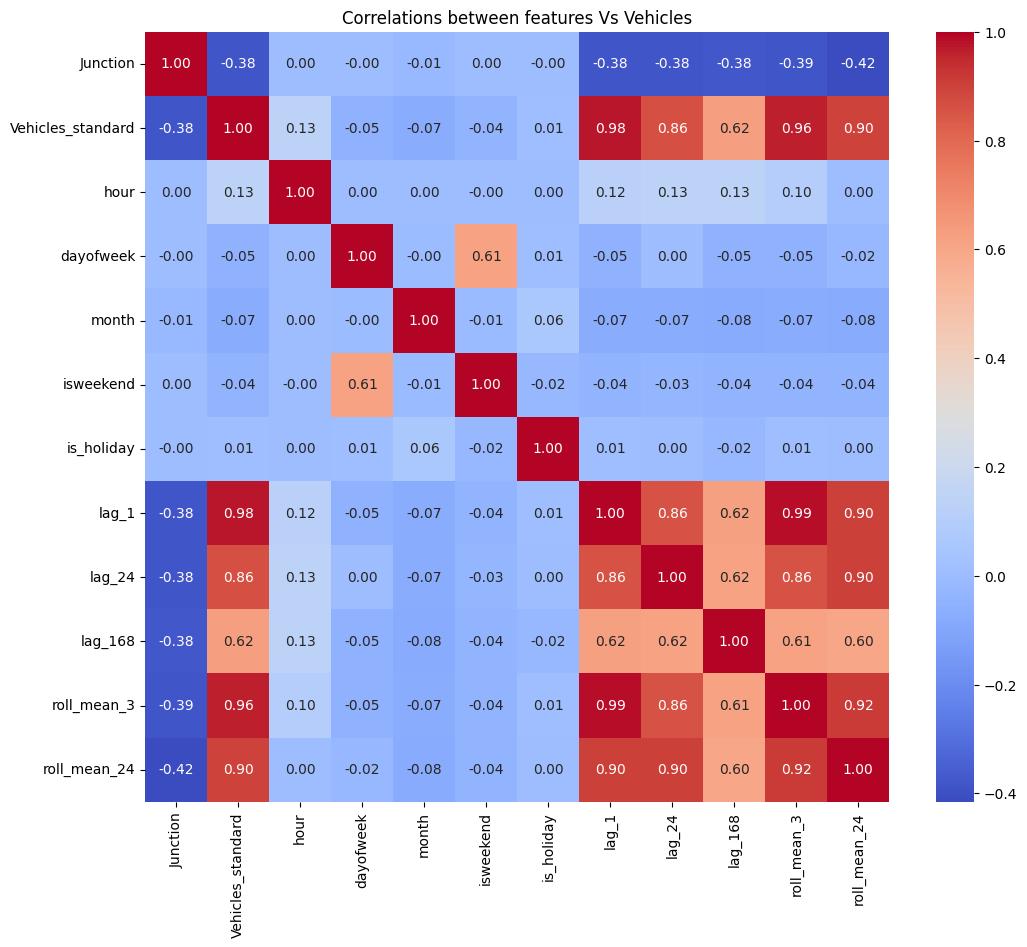

In [45]:
# Heatmap for correlations
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot = True, cmap = 'coolwarm',fmt = ".2f")
plt.title("Correlations between features Vs Vehicles")
plt.show()

In [46]:
# Feature importance by Random forest model
from sklearn.ensemble import RandomForestRegressor

In [47]:
features = ['hour', 'dayofweek', 'month', 'isweekend', 'is_holiday', 'lag_1', 'lag_24',
       'lag_168', 'roll_mean_3', 'roll_mean_24']

x = hourly_scaled[features]
y = hourly_scaled['Vehicles_standard']

In [48]:
RF = RandomForestRegressor(n_estimators=100,random_state=42,n_jobs=-1)
RF.fit(x,y)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [49]:
# find the features importances
rf_importances = RF.feature_importances_
importance_df = pd.DataFrame({"Features" : features,"importances": rf_importances}).sort_values(by="importances",ascending=False)

In [50]:
importance_df.head()

,Features,importances
5,lag_1,0.956253
0,hour,0.012797
9,roll_mean_24,0.007902
8,roll_mean_3,0.007392
6,lag_24,0.005039


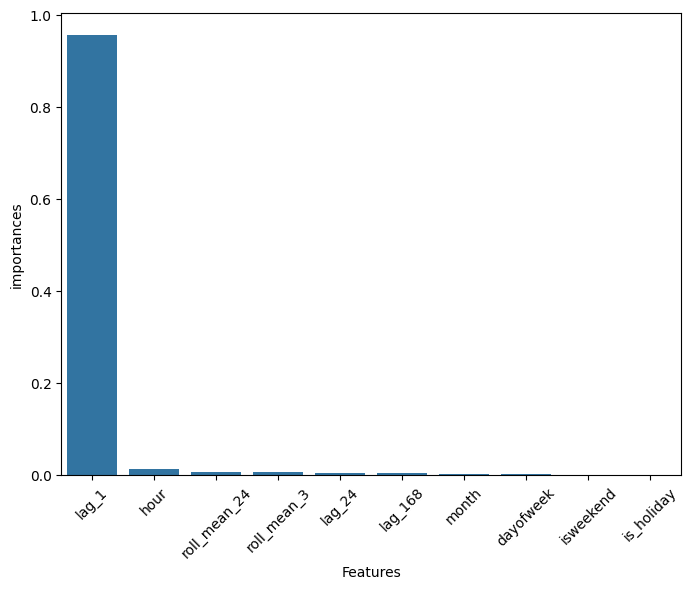

In [51]:
#sns.barplot(data=importance_df,x)
plt.figure(figsize=(8,6))
sns.barplot(data=importance_df,x="Features", y="importances")
plt.xticks(rotation = 45)
plt.show()

In [92]:
# most influential features for model training to improve efficiency and performance.
influential_features = importance_df['Features'].head(5).tolist()
influential_features

['lag_1', 'hour', 'roll_mean_24', 'roll_mean_3', 'lag_24']

## Component -3: Industry Research, Data Collection & Integration

#### 1.Identify and access relevant data sources

In [97]:
# Weather data: Collect historical weather data from meteorological services, including temperature, precipitation, humidity, and wind speed.
#%pip install meteostat
from datetime import datetime
#from meteostat import Hourly , Point

In [99]:
start_date = hourly_scaled['DateTime'].min()
end_date = hourly_scaled['DateTime'].max()
start_date,end_date

(Timestamp('2015-01-18 00:00:00'), Timestamp('2017-12-06 23:00:00'))

In [101]:
import requests

# Hyderabad coordinates
lat, lon = 17.3850, 78.4867
start_date, end_date =  "2015-01-18" , "2017-12-06"

# Open-Meteo API endpoint
url = (
    "https://archive-api.open-meteo.com/v1/archive"
    f"?latitude={lat}&longitude={lon}"
    "&hourly=temperature_2m,precipitation,relative_humidity_2m,windspeed_10m"
    f"&start_date={start_date}&end_date={end_date}"
    "&timezone=Asia%2FKolkata"
)

#print("Fetching:", url)
r = requests.get(url)
r.raise_for_status()
data = r.json()

# Convert to DataFrame
hourly = data["hourly"]
weather = pd.DataFrame({
    "DateTime": pd.to_datetime(hourly["time"]),
    "temperature": hourly["temperature_2m"],
    "precipitation": hourly["precipitation"],
    "humidity": hourly["relative_humidity_2m"],
    "windspeed": hourly["windspeed_10m"]
})

#weather_df.to_csv("hyderabad_hourly_weather_2015_2017.csv", index=False)
weather

,DateTime,temperature,precipitation,humidity,windspeed
0,2015-01-18 00:00:00,17.0,0.0,48,8.0
1,2015-01-18 01:00:00,16.3,0.0,51,8.1
2,2015-01-18 02:00:00,15.7,0.0,53,8.1
3,2015-01-18 03:00:00,15.2,0.0,55,8.0
4,2015-01-18 04:00:00,14.7,0.0,56,8.0
...,...,...,...,...,...
25291,2017-12-06 19:00:00,24.3,0.0,60,11.5
25292,2017-12-06 20:00:00,22.4,0.0,67,8.0
25293,2017-12-06 21:00:00,21.7,0.0,71,7.6
25294,2017-12-06 22:00:00,20.7,0.0,76,5.6


In [102]:
# Event data: Gather information on special events (sports events, concerts, public holidays) from local event calendars and news sources.

In [105]:
#======================================================================================================================================================

In [107]:
import requests
import pandas as pd
from datetime import datetime

# ---------- 1. Sports Events (TheSportsDB) ----------
def fetch_sports_events(team="India", season="2023-2024"):
    url = f"https://www.thesportsdb.com/api/v1/json/3/searchevents.php?e={team}&s={season}"
    try:
        resp = requests.get(url)
        data = resp.json()
        events = data.get("event", [])
        return pd.DataFrame([{
            "Type": "Sport",
            "Event": e.get("strEvent"),
            "Date": e.get("dateEvent"),
            "City": e.get("strVenue"),
        } for e in events])
    except Exception as e:
        print("⚠️ Sports API failed:", e)
        return pd.DataFrame()

# ---------- 2. Public Holidays (OpenHolidays API) ----------
def fetch_public_holidays(country="IN", year=2023):
    url = f"https://www.openholidaysapi.org/api/v1/holidays?country={country}&year={year}"
    try:
        resp = requests.get(url)
        holidays = resp.json().get("holidays", [])
        return pd.DataFrame([{
            "Type": "Holiday",
            "Event": h.get("name"),
            "Date": h.get("date"),
            "City": "Nationwide"
        } for h in holidays])
    except Exception as e:
        print("⚠️ Holidays API failed:", e)
        return pd.DataFrame()

# ---------- 3. Concerts (Songkick Scraper Placeholder) ----------
def fetch_concerts(city="hyderabad"):
    return pd.DataFrame([{
        "Type": "Concert",
        "Event": "Sample Concert",
        "Date": "2023-10-15",
        "City": city.title()
    }])

# ---------- 4. Demonstrations (Eventbrite Scraper Placeholder) ----------
def fetch_demonstrations(city="hyderabad"):
    return pd.DataFrame([{
        "Type": "Demonstration",
        "Event": "Sample Protest",
        "Date": "2023-10-20",
        "City": city.title()
    }])

# ---------- Combine All ----------
def gather_all_events(city="hyderabad", year=2023):
    df_sports = fetch_sports_events()
    df_holidays = fetch_public_holidays(year=year)
    df_concerts = fetch_concerts(city)
    df_demos = fetch_demonstrations(city)
    df_all = pd.concat([df_sports, df_holidays, df_concerts, df_demos], ignore_index=True)
    return df_all

# ---------- Run ----------
df_events = gather_all_events("hyderabad", year=2023)
print("Fetched:", len(df_events), "events")
print(df_events.head(10))

df_events.to_csv("hyderabad_special_events.csv", index=False)
print("✅ Saved to hyderabad_special_events.csv")

⚠️ Holidays API failed: Expecting value: line 1 column 1 (char 0)
Fetched: 27 events
    Type                                      Event        Date  \
0  Sport           Indiana Pacers vs Boston Celtics  2024-05-28   
1  Sport           Indiana Pacers vs Boston Celtics  2024-05-26   
2  Sport          Indiana Pacers vs New York Knicks  2024-05-18   
3  Sport          Indiana Pacers vs New York Knicks  2024-05-12   
4  Sport          Indiana Pacers vs New York Knicks  2024-05-10   
5  Sport          Indiana Pacers vs Milwaukee Bucks  2024-05-02   
6  Sport    Indiana Mad Ants vs Delaware Blue Coats  2024-04-02   
7  Sport     Indiana Mad Ants vs Westchester Knicks  2023-12-23   
8  Sport  Indiana Mad Ants vs College Park Skyhawks  2023-12-21   
9  Sport     Indiana Mad Ants vs Capital City Go-Go  2023-12-19   

                    City  
0  Gainbridge Fieldhouse  
1  Gainbridge Fieldhouse  
2  Gainbridge Fieldhouse  
3  Gainbridge Fieldhouse  
4  Gainbridge Fieldhouse  
5  Gainbridge F

In [108]:
import pandas as pd

# Read the data
df = pd.read_csv('hyderabad_special_events.csv')

# Strip any extra spaces from column names
df.columns = df.columns.str.strip()

# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Get all unique dates that have special events
event_dates = df['Date'].dt.date.unique()

# Create complete datetime range for all years (2015-2017)
start_date = '2015-01-18'
end_date = '2017-12-06'
all_dates = pd.date_range(start=start_date, end=end_date, freq='D')

# Create hourly basis for all dates (24 hours per day)
hourly_dates = []
for date in all_dates:
    for hour in range(24):
        hourly_dates.append(date.replace(hour=hour, minute=0, second=0))

# Create final dataframe
events_df = pd.DataFrame({'datetime': hourly_dates})

# Extract date part from hourly datetimes for comparison
events_df['Date'] = events_df['datetime'].dt.date

# Mark special events (1 if date exists in original event dates, else 0)
events_df['is_special_event'] = events_df['Date'].isin(event_dates).astype(int)

# Drop the temporary date column
events_df = events_df.drop('Date', axis=1)

# Rename datetime column
events_df.rename(columns={'datetime': 'DateTime'}, inplace=True)

events_df.head()


,DateTime,is_special_event
0,2015-01-18 00:00:00,0
1,2015-01-18 01:00:00,0
2,2015-01-18 02:00:00,0
3,2015-01-18 03:00:00,0
4,2015-01-18 04:00:00,0


#### 2. Integrate data from various sources:

In [110]:
# First merge traffic_data with weather_data
weather_merged = pd.merge(hourly_scaled,weather, on ='DateTime', how='left')
weather_merged

,Junction,DateTime,Vehicles_standard,hour,dayofweek,month,isweekend,is_holiday,lag_1,lag_24,lag_168,roll_mean_3,roll_mean_24,temperature,precipitation,humidity,windspeed
0,1,2015-01-18 00:00:00,-0.672136,0,6,1,1,0,-0.672136,-0.672136,0.105143,-0.672136,-0.672136,17.0,0.0,48,8.0
1,1,2015-01-18 01:00:00,-0.672136,1,6,1,1,0,-0.672136,-0.672136,0.001506,-0.672136,-0.672136,16.3,0.0,51,8.1
2,1,2015-01-18 02:00:00,-0.672136,2,6,1,1,0,-0.672136,-0.672136,-0.153950,-0.672136,-0.672136,15.7,0.0,53,8.1
3,1,2015-01-18 03:00:00,-0.672136,3,6,1,1,0,-0.672136,-0.672136,-0.309406,-0.672136,-0.672136,15.2,0.0,55,8.0
4,1,2015-01-18 04:00:00,-0.672136,4,6,1,1,0,-0.672136,-0.672136,-0.205768,-0.672136,-0.672136,14.7,0.0,56,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83875,4,2017-12-06 19:00:00,-0.153950,19,2,12,0,0,-0.205768,-0.464861,-0.672136,-0.050313,-0.318042,24.3,0.0,60,11.5
83876,4,2017-12-06 20:00:00,-0.309406,20,2,12,0,0,-0.153950,-0.205768,-0.672136,-0.153950,-0.305087,22.4,0.0,67,8.0
83877,4,2017-12-06 21:00:00,-0.257587,21,2,12,0,0,-0.309406,-0.309406,-0.672136,-0.223041,-0.309406,21.7,0.0,71,7.6
83878,4,2017-12-06 22:00:00,-0.102131,22,2,12,0,0,-0.257587,-0.413043,-0.672136,-0.240314,-0.307247,20.7,0.0,76,5.6


In [111]:
# Merge weather_merged data with the special_events data
final_df = pd.merge(weather_merged, events_df, on ='DateTime', how = 'left')
final_df

,Junction,DateTime,Vehicles_standard,hour,dayofweek,month,isweekend,is_holiday,lag_1,lag_24,lag_168,roll_mean_3,roll_mean_24,temperature,precipitation,humidity,windspeed,is_special_event
0,1,2015-01-18 00:00:00,-0.672136,0,6,1,1,0,-0.672136,-0.672136,0.105143,-0.672136,-0.672136,17.0,0.0,48,8.0,0
1,1,2015-01-18 01:00:00,-0.672136,1,6,1,1,0,-0.672136,-0.672136,0.001506,-0.672136,-0.672136,16.3,0.0,51,8.1,0
2,1,2015-01-18 02:00:00,-0.672136,2,6,1,1,0,-0.672136,-0.672136,-0.153950,-0.672136,-0.672136,15.7,0.0,53,8.1,0
3,1,2015-01-18 03:00:00,-0.672136,3,6,1,1,0,-0.672136,-0.672136,-0.309406,-0.672136,-0.672136,15.2,0.0,55,8.0,0
4,1,2015-01-18 04:00:00,-0.672136,4,6,1,1,0,-0.672136,-0.672136,-0.205768,-0.672136,-0.672136,14.7,0.0,56,8.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83875,4,2017-12-06 19:00:00,-0.153950,19,2,12,0,0,-0.205768,-0.464861,-0.672136,-0.050313,-0.318042,24.3,0.0,60,11.5,0
83876,4,2017-12-06 20:00:00,-0.309406,20,2,12,0,0,-0.153950,-0.205768,-0.672136,-0.153950,-0.305087,22.4,0.0,67,8.0,0
83877,4,2017-12-06 21:00:00,-0.257587,21,2,12,0,0,-0.309406,-0.309406,-0.672136,-0.223041,-0.309406,21.7,0.0,71,7.6,0
83878,4,2017-12-06 22:00:00,-0.102131,22,2,12,0,0,-0.257587,-0.413043,-0.672136,-0.240314,-0.307247,20.7,0.0,76,5.6,0


#### 3. Handle data quality issues:

In [117]:
final_df.duplicated().sum()

np.int64(0)

In [119]:
final_df.isnull().sum()

Junction             0
DateTime             0
Vehicles_standard    0
hour                 0
dayofweek            0
month                0
isweekend            0
is_holiday           0
lag_1                0
lag_24               0
lag_168              0
roll_mean_3          0
roll_mean_24         0
temperature          0
precipitation        0
humidity             0
windspeed            0
is_special_event     0
dtype: int64

In [121]:
# Standardization of the columns related to weather
final_df.columns

Index(['Junction', 'DateTime', 'Vehicles_standard', 'hour', 'dayofweek',
       'month', 'isweekend', 'is_holiday', 'lag_1', 'lag_24', 'lag_168',
       'roll_mean_3', 'roll_mean_24', 'temperature', 'precipitation',
       'humidity', 'windspeed', 'is_special_event'],
      dtype='object')

In [123]:
features = ['temperature','precipitation', 'humidity', 'windspeed']
final_df[features] = scaler.fit_transform(final_df[features])

In [125]:
final_df.head()

,Junction,DateTime,Vehicles_standard,hour,dayofweek,month,isweekend,is_holiday,lag_1,lag_24,lag_168,roll_mean_3,roll_mean_24,temperature,precipitation,humidity,windspeed,is_special_event
0,1,2015-01-18 00:00:00,-0.672136,0,6,1,1,0,-0.672136,-0.672136,0.105143,-0.672136,-0.672136,-1.957044,-0.209214,-0.541137,-0.538784,0
1,1,2015-01-18 01:00:00,-0.672136,1,6,1,1,0,-0.672136,-0.672136,0.001506,-0.672136,-0.672136,-2.101672,-0.209214,-0.406208,-0.520320,0
2,1,2015-01-18 02:00:00,-0.672136,2,6,1,1,0,-0.672136,-0.672136,-0.153950,-0.672136,-0.672136,-2.225639,-0.209214,-0.316255,-0.520320,0
3,1,2015-01-18 03:00:00,-0.672136,3,6,1,1,0,-0.672136,-0.672136,-0.309406,-0.672136,-0.672136,-2.328945,-0.209214,-0.226302,-0.538784,0
4,1,2015-01-18 04:00:00,-0.672136,4,6,1,1,0,-0.672136,-0.672136,-0.205768,-0.672136,-0.672136,-2.432251,-0.209214,-0.181326,-0.538784,0
